# Wine Quality


In [13]:
import numpy as np
import pandas as pd

wine_data = pd.read_csv("winequality-red.csv", delimiter=";")

**Our hypothesis**: It is possible to predict a wine's subjective quality based on objective, easily measured characteristics, such as pH and alcohol content.

Our data comes from https://archive.ics.uci.edu/ml/datasets/Wine+Quality and includes data related to red and white variants of the Portuguese "Vinho Verde" wine. For simplicity, we're focusing on the red wine data set.

First, let's take a look at what's in the data:
    

In [2]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


To get a baseline sense of the predictability of our data, let's run a simple linear regression and score it.

In [3]:
predictors = list(wine_data.columns)
predictors.remove("quality")

In [4]:
from sklearn.preprocessing import StandardScaler

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    estimator.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)

    print("Model: {}\nScore: {}\n".format(estimator.__class__.__name__, r2_score(expected, predicted)))

In [5]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

score_model(wine_data[predictors], wine_data["quality"], linear_model.LinearRegression())

Model: LinearRegression
Score: 0.33394762575570736



Interesting! So a simple linear regression can predict about 33% of the variation in quality. Let's see if we can improve on that. To start, let's run a ridge regression to identify which variables are most important, supporting feature selection.

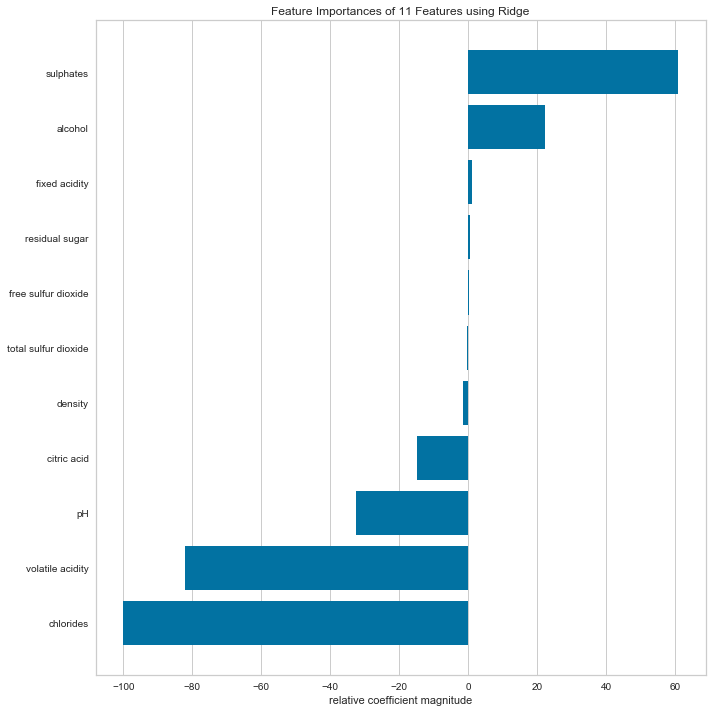

In [6]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from yellowbrick.features.importances import FeatureImportances

%matplotlib inline

ridge = Ridge(alpha=1)
ridge.fit(wine_data[predictors], wine_data["quality"])

# Create a new matplotlib figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(figsize=(10,10))

viz = FeatureImportances(ridge, ax=ax)
viz.fit(wine_data[predictors], wine_data["quality"])
viz.poof()

Clearly, many of these variables have little relationship to quality and may confuse our model. Let's drop them, then visualize the relationships among the remaining variables:

In [7]:
vars_to_remove = ["fixed acidity", "residual sugar", "free sulfur dioxide", "total sulfur dioxide", "density", "citric acid"]
for var in vars_to_remove:
    predictors.remove(var)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


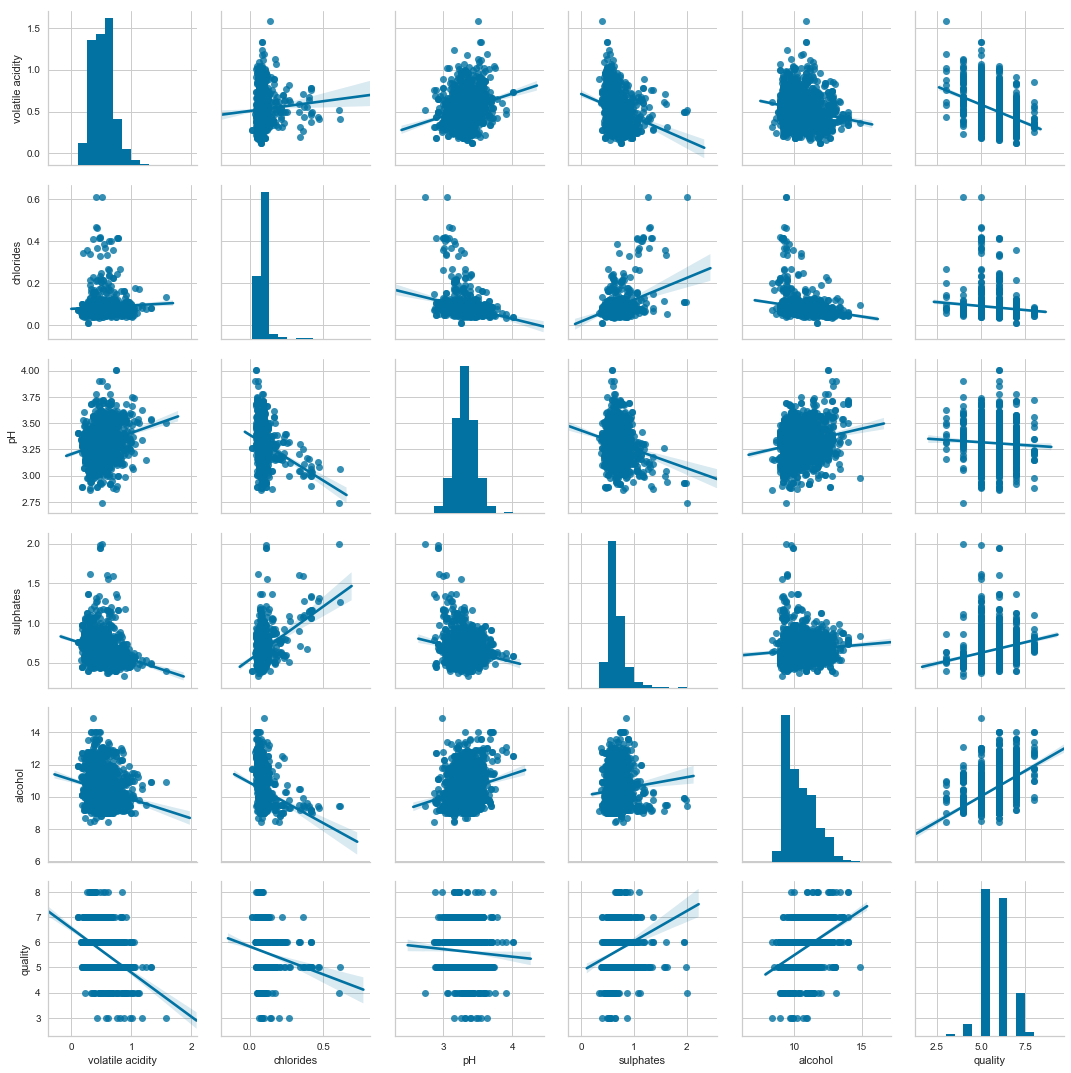

In [11]:
import seaborn as sns
sns.pairplot(wine_data[predictors + ["quality"]],kind='reg')

Now, let's test a bunch of different model types to see if any can improve on our simple linear regression. We'll check both some classifier and regressor algorithms.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
score_model(wine_data[predictors], wine_data["quality"], GradientBoostingClassifier(n_estimators=100))

from sklearn.naive_bayes import GaussianNB
score_model(wine_data[predictors], wine_data["quality"], GaussianNB())

from sklearn.linear_model import LogisticRegression
score_model(wine_data[predictors], wine_data["quality"], LogisticRegression())

from sklearn.ensemble import GradientBoostingRegressor
score_model(wine_data[predictors], wine_data["quality"], GradientBoostingRegressor(n_estimators=100))

score_model(wine_data[predictors], wine_data["quality"], Ridge(alpha=1))

from sklearn.svm import SVR
score_model(wine_data[predictors], wine_data["quality"], SVR(kernel="rbf"))

score_model(wine_data[predictors], wine_data["quality"], linear_model.LinearRegression())

Model: GradientBoostingClassifier
Score: 0.24837388581064812

Model: GaussianNB
Score: 0.09968050102525794

Model: LogisticRegression
Score: 0.22741753453620783

Model: GradientBoostingRegressor
Score: 0.400776694111978

Model: Ridge
Score: 0.3062391208185047

Model: SVR
Score: 0.37075523869921845

Model: LinearRegression
Score: 0.3472114999157331



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


It looks like the GradientBoostingRegressor and SVR are our best bet, so let's do a grid search to tune their hyperparameters.

In [60]:
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor(n_estimators=100)
tuned_parameters = [{'learning_rate':[.01, .03,.05], 'max_depth':[4, 6, 8], 'min_samples_leaf':[1, 2, 3, 4]}]

grid = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=5)
grid.fit(wine_data[predictors], wine_data["quality"])
print(grid.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [40]:
model = SVR(kernel="rbf", C=1000, gamma=.01)
tuned_parameters = [{'C':[1, 10, 100, 1000], 'gamma':[0.001, 0.01, 0.1, 1]}]

grid = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=5)
grid.fit(wine_data[predictors], wine_data["quality"])
print(grid.best_estimator_)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Now let's check the R2 score of these tuned models:

In [61]:
best_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

best_svr = SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
             kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


score_model(wine_data[predictors], wine_data["quality"], best_gbr)
score_model(wine_data[predictors], wine_data["quality"], best_svr)

Model: GradientBoostingRegressor
Score: 0.42062859324643975

Model: SVR
Score: 0.36408630432466405



Based on this basic exploration, it appears that the Gradient Boosting Regressor is our best-performing model, producing an R2 score of about .42 -- a significant improvement on the .33 of the linear regression we ran at the beginning of our exploration. 

Even better, this model uses only 6 of the original 11 variables, which in a real-world context might translate to lower costs to evaluate new wines.